In [94]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import datetime
import time
import matplotlib
import base
import predict


import matplotlib
myfont = matplotlib.font_manager.FontProperties(fname=r'C:/Windows/Fonts/msyh.ttf')
matplotlib.use('qt4agg')  
#指定默认字体  
matplotlib.rcParams['font.sans-serif'] = ['SimHei']   
matplotlib.rcParams['font.family']='sans-serif'  
#解决负号'-'显示为方块的问题  
matplotlib.rcParams['axes.unicode_minus'] = False   

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


C:\Program Files\Anaconda3\lib\site-packages\matplotlib\__init__.py:1357: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [3]:
#读取user_pay_count
user_pay_counts = base.ReadUserPayCountCSV();
#读取开店时间数据
shop_open_dates = base.ReadShopOpenDateCSV();
###读取商家信息
shop_infos = base.ReadShopInfoCSV();
##读取城市名称对照表
city_names = base.ReadCityNameCSV();
#读取休假表
calenders = base.ReadCalendarCSV();
#读取用户浏览数据表
user_view_counts = base.ReadUserViewCSV();

In [95]:
%reload_ext autoreload

In [43]:
def plotHolidayPayCounts(shop_id, day_type, time_ranges, colors):
    
    info = shop_infos.ix[shop_id]
    week_means = []
    f, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))
    i = 0
    for tr in time_ranges:
        
        holiday_df = base.getHolidayPayCount(
            shop_id, day_type, shop_open_dates, user_pay_counts, calenders, tr[0], tr[1])
    
        holiday_df = holiday_df.reset_index(drop=True)
    
        ax1.plot(holiday_df.index, holiday_df['count'], color=colors[i], label=str(i))

        plt.title(info.cate_1_name + ' ' + info.cate_2_name + ('' if info.cate_3_name is None else info.cate_3_name), fontproperties=myfont)
        week_means.append(np.mean(holiday_df['count']))
        
        i = i + 1

    ax2.plot(range(len(week_means)), week_means)
    plt.legend()
    plt.show()
    
    

C:\Program Files\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


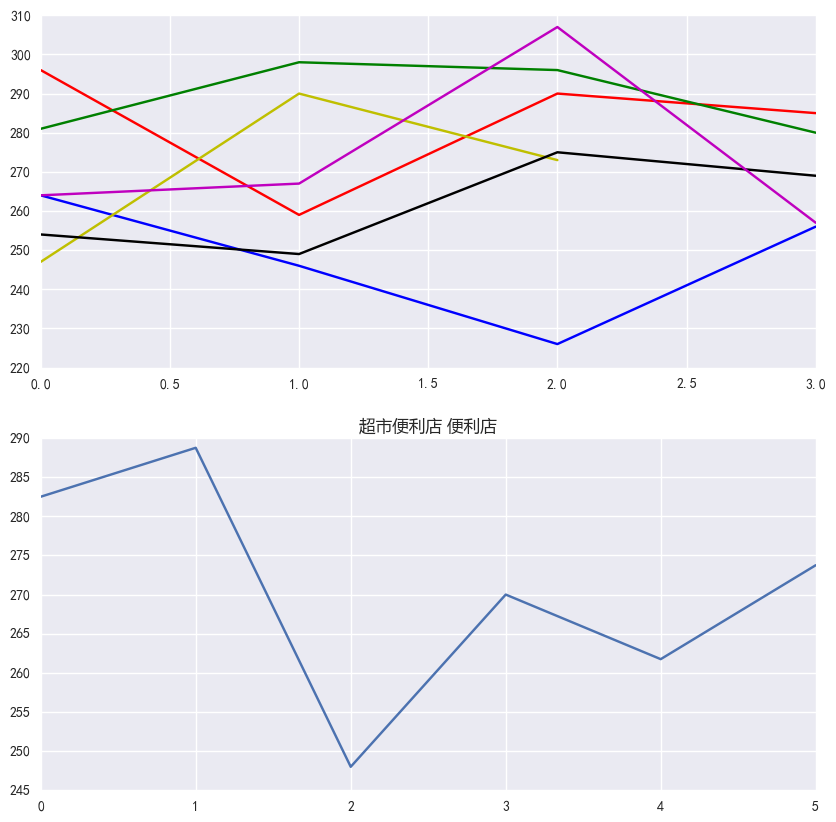

In [44]:
id = 1379
day_type = 1
time_ranges = [];
# time_ranges.append([pd.to_datetime('2016-8-18'), pd.to_datetime('2016-8-24')])
# time_ranges.append([pd.to_datetime('2016-8-25'), pd.to_datetime('2016-8-31')])
# time_ranges.append([pd.to_datetime('2016-9-1'), pd.to_datetime('2016-9-7')])
# time_ranges.append([pd.to_datetime('2016-9-8'), pd.to_datetime('2016-9-14')])
# time_ranges.append([pd.to_datetime('2016-9-15'), pd.to_datetime('2016-9-21')])
# time_ranges.append([pd.to_datetime('2016-9-22'), pd.to_datetime('2016-9-28')])
# colors = ['r', 'g', 'b', 'y', 'k', 'm']
plotHolidayPayCounts(id, day_type, time_ranges, colors)

In [91]:
def initWeekDate(shop_id, end_time, week_num):
    time_ranges = []
    open_time = shop_open_dates.loc[id]['date'];
    if open_time > end_time:
        return 1
    
    while(week_num > 0):
        
        start_time = end_time - datetime.timedelta(weeks=1);
        time_ranges.append([start_time, end_time])
        
        week_num = week_num - 1;
        end_time = start_time
        
    time_ranges.reverse()
    return time_ranges

def predictWeekPayCount(shop_id, day_type, time_ranges):
    
    real_week_means = []
    predict_one_week_means = []
    predict_two_week_means = []
    predict_mix_week_means = []
    
    for i, tr in enumerate(time_ranges):
        holiday_df = base.getHolidayPayCount(
            shop_id, day_type, shop_open_dates, user_pay_counts, calenders, tr[0], tr[1])

        real_week_means.append(np.mean(holiday_df['count']))
        if i >= 2:
            predict_one_week_means.append((real_week_means[i - 2] + real_week_means[i - 1]) / 2)

        if i >= 2:
            if (i % 2) == 0:
                predict_mix_week_means.append((real_week_means[i - 2] + real_week_means[i - 1]) / 2)
            else:
                predict_mix_week_means.append((real_week_means[i - 2] + predict_one_week_means[i - 1 - 2]) / 2)

        if i >= 2:
            if (i % 2) == 0:
                predict_two_week_means.append((real_week_means[i - 2] + real_week_means[i - 1]) / 2)
            else:
                predict_two_week_means.append((real_week_means[i - 3] + real_week_means[i - 2]) / 2)

            
    return real_week_means, predict_mix_week_means, predict_two_week_means



def plotHolidayWeekMeanPayCounts(shop_id, real, predict_mix, predict_two):
    
    info = shop_infos.ix[shop_id]
    f, (ax1) = plt.subplots(1, 1, figsize=(10, 5))
    ax1.plot(range(len(real)), real, color='r', label='real')
    ax1.plot(range(2, (len(predict_two) + 2)), predict_two, color='b', label='predict_two')
    ax1.plot(range(2, (len(predict_mix) + 2)), predict_mix, color='g', label='predict_mix')
    
    
    plt.title(info.cate_1_name + ' ' + info.cate_2_name + ('' if info.cate_3_name is None else info.cate_3_name), fontproperties=myfont)
    plt.legend()
    plt.show()

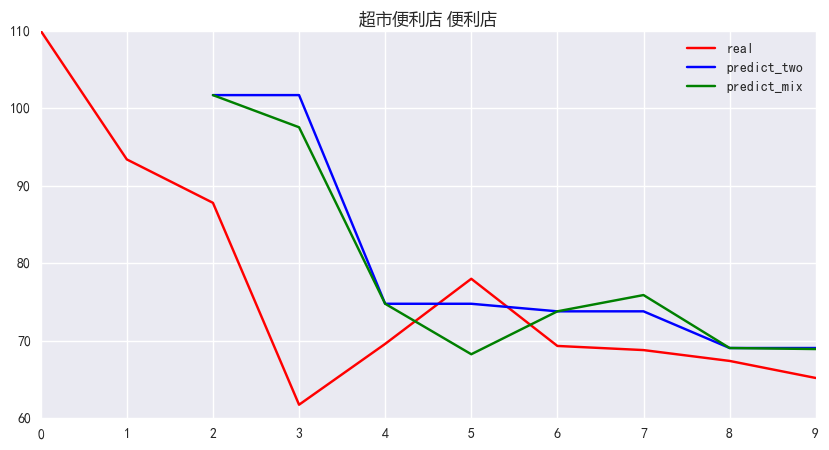

In [93]:
shop_id = 567
day_type = 1
#第二个点比较才有意义
time_ranges = initWeekDate(shop_id, pd.to_datetime('2016-10-31'), 10)
real, predict_mix, predict_two = predictWeekPayCount(shop_id, day_type, time_ranges)
plotHolidayWeekMeanPayCounts(shop_id, real, predict_mix, predict_two)